## CNN

In [23]:
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os, sys, glob
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torchvision import models

import segmentation_models_pytorch as smp
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    print("Name of the Graphics card", torch.cuda.get_device_name())
    print("Number of GPU available", torch.cuda.device_count())
    device = "cuda"
else:
    print("No GPU available on this machine")
    device = "cpu"

No GPU available on this machine


In [5]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [6]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


Text(0.5, 1.0, 'real and groundtruth images')

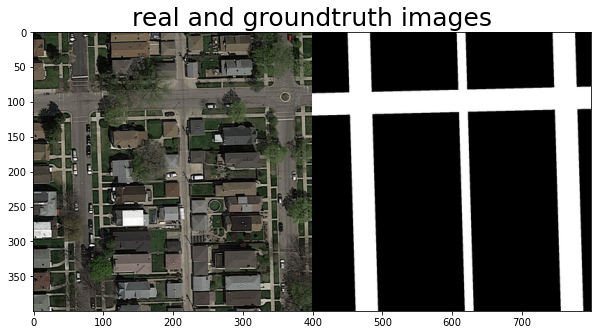

In [7]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("real and groundtruth images", fontdict={'fontsize':25})

In [8]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [186]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X 

#### Loading the training set

In [187]:
# Class describing the training dataset used by the CNN
class TrainsetCNN(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = torch.tensor(y).long()
        self.length = self.x.shape[0] # Number of image patches in the dataset
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = augmentation
        else:
            self.augmentation = T.Compose([T.ToTensor()]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.y[idx]

    def __len__(self):
        return self.length



#### Training and Validation datasets

In [188]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [189]:
# Building a balanced training dataset (the original dataset of image patches is imbalanced between the two classes)
def balanced_training_set (img_patches, label_patches):
    # Splitting the imbalanced dataset between the two classes (road and background)
    roads = img_patches[label_patches == 1]
    nb_roads = len(roads)
    backgrounds = img_patches[label_patches == 0]
    nb_backgrounds = len(backgrounds)
    # Building a balanced dataset for training the CNN
    img_balanced = []
    label_balanced = []
    for i in range (max(nb_roads, nb_backgrounds)):
        img_balanced.append(roads[i % nb_roads])
        img_balanced.append(backgrounds[i % nb_backgrounds])
        label_balanced.append(1)
        label_balanced.append(0)
    return img_balanced, label_balanced

In [190]:
# Trainset and Validation sets
img_balanced, label_balanced = balanced_training_set(img_patches, Y)
img_train, img_valid, Y_train, Y_valid = train_test_split(np.asarray(img_balanced), np.asarray(label_balanced), test_size=0.33, random_state=42)

batch_size = 10
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, shuffle=True)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))

Number of patches in the training dataset: 12663
Number of patches in the validation dataset: 6237


In [191]:
"""# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.33, random_state=42)

batch_size = 10
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, shuffle=True)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))"""

'# Trainset and Validation sets\nimg_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.33, random_state=42)\n\nbatch_size = 10\ndataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, shuffle=True)\ndataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)\n\nprint("Number of patches in the training dataset: {}".format(len(img_train)))\nprint("Number of patches in the validation dataset: {}".format(len(img_valid)))'

In [192]:
"""# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.33, random_state=42)

# the training set is imbalanced (too few roads) => defining weights for the classes
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
weights = class_weights[Y_train]
weights = torch.tensor(weights, dtype=torch.float32)
print("Dealing with imbalanced datasets")
print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

batch_size = 10
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, sampler=sampler)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))"""

'# Trainset and Validation sets\nimg_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.33, random_state=42)\n\n# the training set is imbalanced (too few roads) => defining weights for the classes\nclass_weights = compute_class_weight(class_weight = \'balanced\', classes = np.unique(Y_train), y = Y_train)\nweights = class_weights[Y_train]\nweights = torch.tensor(weights, dtype=torch.float32)\nprint("Dealing with imbalanced datasets")\nprint("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))\n\nbatch_size = 10\nsampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))\ndataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, sampler=sampler)\ndataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)\n\nprint("Number of patches in the training dataset: {}".format(len(img_train)))\nprint("Number of patches in the validation dataset

#### Training the CNN

In [193]:
class LeNetModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(200)
        self.conv2 = nn.Conv2d(200, 400, kernel_size=5)
        self.batch_norm2 = nn.BatchNorm2d(400)

        self.fc1 = nn.Linear(400, 100)
        self.fc2 = nn.Linear(100, 2)


    def forward(self, x):
        # Convolutional Layers
        x = self.batch_norm1(leaky_relu(max_pool2d(self.conv1(x), 2)))
        x = dropout(x, 0.25, training=self.training)
        x = self.batch_norm2(leaky_relu(max_pool2d(self.conv2(x), 2)))
        x = dropout(x, 0.25, training=self.training)

        x = x.view(x.shape[0], -1)

        # Fully Connected Layers
        x = leaky_relu(self.fc1(x))
        x = dropout(x, 0.25, training=self.training)
        x = leaky_relu(self.fc2(x))
        x = dropout(x, 0.25, training=self.training)
        x = softmax(x, dim=1)

        return x

In [194]:
def train(model, criterion, dataset_train, dataset_valid, optimizer, num_epochs):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.loss._Loss
    @param dataset_train: torch.utils.data.DataLoader
    @param dataset_valid: torch.utils.data.DataLoader
    @param optimizer: torch.optim.Optimizer
    @param num_epochs: int
    """
    print("Starting training")

    loss_train = []
    loss_valid = []

    for epoch in range(num_epochs):
        # Train an epoch
        model.train()
        running_loss = 0.
        for batch_x, batch_y in tqdm(dataset_train):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(running_loss / len(dataset_train))


        # Test the quality on the validation set
        model.eval()
        accuracies_valid = []
        f1_valid = []
        running_loss = 0.
        for batch_x, batch_y in dataset_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            accuracies_valid.append(accuracy(prediction, batch_y))
            f1_valid.append(f1_score(batch_y.detach(), np.argmax(prediction.detach(), 1)))

        loss_valid.append(running_loss / len(dataset_valid))

        # Printing statistics
        accuracy_epoch = sum(accuracies_valid) / len(accuracies_valid)
        f1_epoch = sum(f1_valid) / len(f1_valid)
        print("Epoch {}".format(epoch + 1))
        print("val accuracy: {:.5f}, f1-score: {:.5f}\n".format(accuracy_epoch, f1_epoch))

    print("Finished")
    return loss_train, loss_valid

In [195]:
# hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [196]:
## hyperparameters
#num_epochs = 10
#learning_rate = 1e-3

## Criterion to optimize
## the training set is imbalanced (too few roads) => defining weights for the classes
#class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
#class_weights = torch.tensor(class_weights, dtype=torch.float32)
#criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

#print("Dealing with imbalanced datasets")
#print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

#### Performance of the Model without Data Augmentation

In [197]:
# plotting the loss curves for the train and the validation sets
def plot_performance (loss_train, loss_valid):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_train)
    plt.plot(epochs, loss_valid)
    plt.legend(["train loss", "validation loss"])
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()

  0%|▎                                                                                | 4/1267 [00:00<01:05, 19.35it/s]

Starting training


  0%|▏                                                                                | 2/1267 [00:00<01:06, 19.10it/s]

Epoch 1
val accuracy: 0.64377, f1-score: 0.67095



  0%|▏                                                                                | 2/1267 [00:00<01:09, 18.23it/s]

Epoch 2
val accuracy: 0.64380, f1-score: 0.54113



  0%|▏                                                                                | 2/1267 [00:00<01:24, 14.97it/s]

Epoch 3
val accuracy: 0.69428, f1-score: 0.65907



  0%|▏                                                                                | 2/1267 [00:00<01:37, 13.02it/s]

Epoch 4
val accuracy: 0.71973, f1-score: 0.68615



  0%|                                                                                 | 1/1267 [00:00<02:08,  9.83it/s]

Epoch 5
val accuracy: 0.69256, f1-score: 0.60815



  0%|▏                                                                                | 2/1267 [00:00<01:35, 13.28it/s]

Epoch 6
val accuracy: 0.73622, f1-score: 0.73196



  0%|▏                                                                                | 2/1267 [00:00<01:16, 16.44it/s]

Epoch 7
val accuracy: 0.68700, f1-score: 0.64996



  0%|▏                                                                                | 2/1267 [00:00<01:12, 17.44it/s]

Epoch 8
val accuracy: 0.75460, f1-score: 0.74813



  0%|▏                                                                                | 3/1267 [00:00<01:01, 20.46it/s]

Epoch 9
val accuracy: 0.66131, f1-score: 0.64162



100%|██████████████████████████████████████████████████████████████████████████████| 1267/1267 [01:08<00:00, 18.46it/s]


Epoch 10
val accuracy: 0.73120, f1-score: 0.71807

Finished


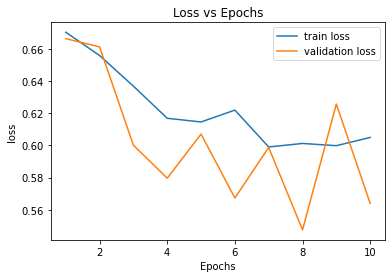

In [198]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, num_epochs)
plot_performance(loss_train, loss_valid)

#### Performance of the Model with Data Augmentation

In [112]:
# Transformation of the original images (Data Augmentation)
augmentation = T.Compose([
    img_float_to_uint8,
    T.ToPILImage(),
    T.RandomVerticalFlip(0.5),  # flipping with probability of 0.5
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    #T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    T.ToTensor(),
])

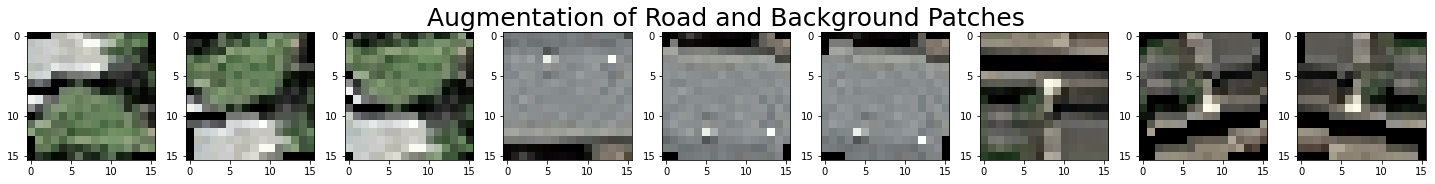

In [113]:
# Visualize possible augmentations for road and background patches from the Training dataset
ind_patches = [1, 5, 9]
fig, ax = plt.subplots(1, 3*len(ind_patches), figsize=(20, 20))
for i in range (3):
    for j in range (len(ind_patches)):
        ax[i + 3*j].imshow(augmentation(img_patches[ind_patches[j]]).permute(1, 2, 0).numpy())

ax[4].set_title("Augmentation of Road and Background Patches", fontdict={'fontsize':25})
plt.tight_layout()

In [114]:
# Augmented Datasets
trainsetAugmented = TrainsetCNN(img_train, Y_train, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, shuffle=True)

In [115]:
# Training the CNN on the Augmented Dataset
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, num_epochs)
plot_performance(loss_train, loss_valid)

  0%|                                                                                         | 0/1267 [00:00<?, ?it/s]

Starting training


  0%|                                                                                         | 0/1267 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

#### Testing the CNN on one image

Text(0.5, 1.0, 'Test Image 1')

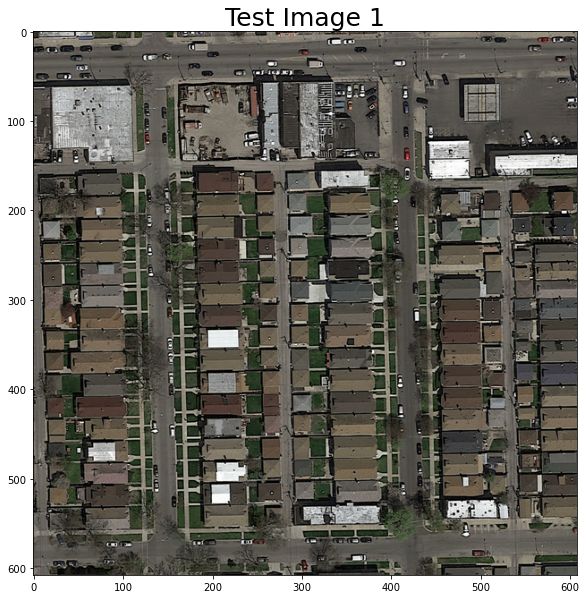

In [199]:
# Load all test images
test_images = list(glob.iglob(image_test + '/*/*.png', recursive=True))

# Extract one test image for visualization
test_1_path = test_images[0]
test_1 = load_image(test_1_path)

# show test image 1
plt.figure(figsize=(10, 10))
plt.imshow(test_1)
plt.title("Test Image 1", fontdict={'fontsize':25})

In [200]:
# Class describing the test dataset
class TestsetCNN(Dataset):
    def __init__(self, x):        
        self.x = x
        self.length = len(self.x)

    def __getitem__(self, idx):
        return T.ToTensor()(self.x[idx])
        
    def __len__(self):
        return self.length

In [201]:
def predict(model, dataset_test):
    """
    @param model: torch.nn.Module
    @param dataset_test: torch.utils.data.DataLoader
    """
    # Running the prediction for the test set
    model.eval()
    predicted_labels = []
    for batch_x in dataset_test:
        predicted_logits = model(batch_x).detach().numpy()
        predicted_labels.append(np.argmax(predicted_logits, 1))
    return np.concatenate(predicted_labels)

True positive rate = 0.15581717451523547


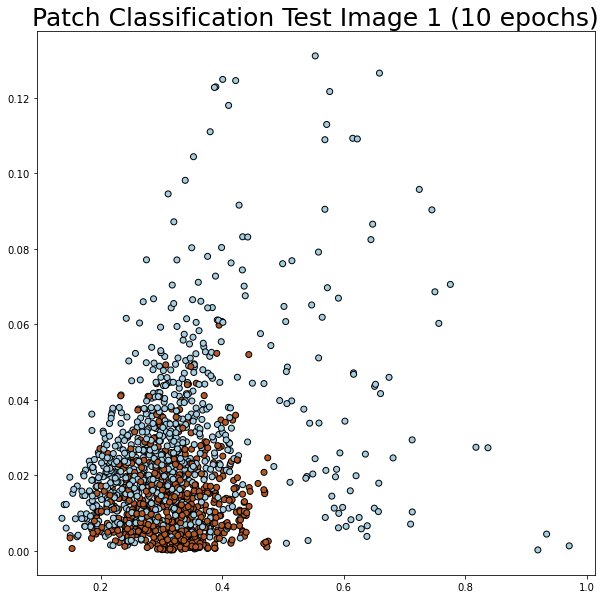

In [202]:
# Test set of image patches
patches_test = np.array(img_crop(test_1, patch_size, patch_size))
dataset_test = torch.utils.data.DataLoader(TestsetCNN(patches_test), batch_size=batch_size, shuffle=False)

# Running the prediction for the test image
Zi = predict(model_lenet, dataset_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(test_1_path)
plt.figure(figsize=(10, 10))
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Patch Classification Test Image 1 ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.show()

In [203]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

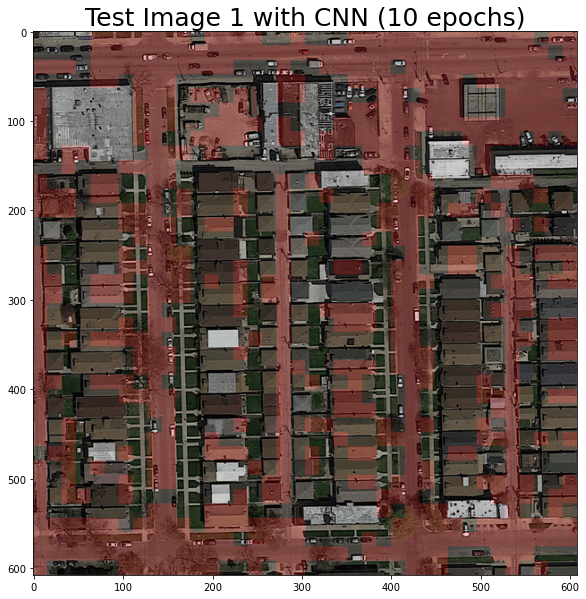

In [204]:
# Display prediction as an image

w = test_1.shape[0]
h = test_1.shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(test_1, predicted_im)
plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_1, predicted_im)

plt.title("Test Image 1 with CNN ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.imshow(new_img)

#### Generating the predictions for the submission

## Comparing the Results using a Pretrained U-Net

#### Training dataset used by the ResNet 50

In [178]:
# Class describing the training set used by the UNet
class TrainsetUNet(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = y
        self.length = len(self.x) # Number of image patches in the dataset
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = augmentation
        else:
            self.augmentation = T.Compose([T.ToTensor()]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.augmentation(self.y[idx])

    def __len__(self):
        return self.length

In [179]:
# Trainset and Validation sets
img_train, img_valid, gt_train, gt_valid = train_test_split(imgs, gt_imgs, test_size=0.33, random_state=42)

batch_size = 10
dataset_train = DataLoader(TrainsetUNet(img_train, gt_train), batch_size=batch_size, shuffle=True)
dataset_valid = DataLoader(TrainsetUNet(img_valid, gt_valid), batch_size=batch_size, shuffle=True)

print("Number of images in the training dataset: {}".format(len(img_train)))
print("Number of images in the validation dataset: {}".format(len(img_valid)))

Number of images in the training dataset: 13
Number of images in the validation dataset: 7


#### Defining the Network U-Net to be used

In [180]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Hyperparameters

In [181]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [184]:
# Training the CNN on the Augmented Dataset
loss_train, loss_valid = train(model, loss, dataset_train, dataset_valid, optimizer, num_epochs)
plot_performance(loss_train, loss_valid)

Starting training
torch.Size([10, 3, 400, 400])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 26 but got size 25 for tensor number 1 in the list.

In [176]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [177]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(dataset_train)
        valid_logs = valid_epoch.run(dataset_valid)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|                                                                                     | 0/2 [00:12<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 26 but got size 25 for tensor number 1 in the list.